In [ ]:
# in this notebook we'll only get one of the files (the Oscar one) for the sake of simplicity and performance
!wget -c https://cdn-datasets.huggingface.co/EsperBERTo/data/oscar.eo.txt

## 2. Train a tokenizer




In [ ]:
# We won't need TensorFlow here
!pip uninstall -y tensorflow
# Install `transformers` from master
!pip install git+https://github.com/huggingface/transformers
!pip list | grep -E 'transformers|tokenizers'
# transformers version at notebook update --- 2.11.0
# tokenizers version at notebook update --- 0.8.0rc1

In [1]:
import pandas as pd

aav2= pd.read_csv("../huggingface/human_virus2.csv")


aav2["sequence"]=aav2["sequence"].str.upper()

aav_data=[]
for line in aav2["sequence"]:
    line2=line.replace(""," ")
    aav_data.append(line2)
    
    

In [2]:
with open("humanized_data.csv", "w", newline='') as csvfile:
    for i in aav_data:
        csvfile.write(i)

        #csvfile.write('\n')

In [3]:
%%time 
from pathlib import Path

from tokenizers import ByteLevelBPETokenizer

paths = [str(x) for x in Path("../huggingface/").glob("humanized_data.csv")]

Wall time: 12 ms


In [4]:
# Initialize a tokenizer
tokenizer = ByteLevelBPETokenizer()

In [5]:
# Customize training
tokenizer.train(files=paths, vocab_size=52_000, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])

In [6]:
tokenizer

Tokenizer(vocabulary_size=281, model=ByteLevelBPE, add_prefix_space=False, lowercase=False, dropout=None, unicode_normalizer=None, continuing_subword_prefix=None, end_of_word_suffix=None, trim_offsets=False)

Now let's save files to disk

In [3]:
!mkdir EsperBERTo

子目录或文件 EsperBERTo 已经存在。


In [27]:
tokenizer.save_model("../huggingface/models/humanzied_bert")

['../huggingface/models/humanzied_bert\\vocab.json',
 '../huggingface/models/humanzied_bert\\merges.txt']

In [7]:
from tokenizers.implementations import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

In [8]:
tokenizer = ByteLevelBPETokenizer(
    "../huggingface/models/aav2bert/vocab.json",
    "../huggingface/models/aav2bert/merges.txt",
)

In [9]:
tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>")),
)
tokenizer.enable_truncation(max_length=512)

In [10]:
tokenizer.encode("DGYLPDWLEDNLSEGIREW")

Encoding(num_tokens=21, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

## 3. Train a language model from scratch




In [11]:
# Check that we have a GPU
!nvidia-smi

Tue Dec 27 12:51:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:03:00.0  On |                  N/A |
|  0%   35C    P8     7W / 170W |    540MiB / 12288MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Check that PyTorch sees it
import torch
torch.cuda.is_available()

C:\Users\racoon\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

### We'll define the following config for the model

In [13]:
from transformers import RobertaConfig

config = RobertaConfig(
    vocab_size=52_000,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
)

Now let's re-create our tokenizer in transformers

In [14]:
from transformers import RobertaTokenizerFast

tokenizer = RobertaTokenizerFast.from_pretrained("../huggingface/models/aav2bert", max_len=512)

Finally let's initialize our model.

**Important:**

As we are training from scratch, we only initialize from a config, not from an existing pretrained model or checkpoint.

In [15]:
from transformers import RobertaForMaskedLM

model = RobertaForMaskedLM(config=config)

In [16]:
model.num_parameters()
# => 84 million parameters

83504416

### Now let's build our training Dataset

We'll build our dataset by applying our tokenizer to our text file.

Here, as we only have one text file, we don't even need to customize our `Dataset`. We'll just use the `LineByLineDataset` out-of-the-box.

In [17]:
%%time
from transformers import LineByLineTextDataset

dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path="D:/jupyter_notebook/huggingface/data/humanized_data.csv",
    block_size=128,
)

C:\Users\racoon\anaconda3\envs\pytorch\lib\site-packages\transformers\data\datasets\language_modeling.py:125: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  FutureWarning,


Wall time: 25.7 s


In [18]:
dataset

Like in the [`run_language_modeling.py`](https://github.com/huggingface/transformers/blob/master/examples/language-modeling/run_language_modeling.py) script, we need to define a data_collator.

This is just a small helper that will help us batch different samples of the dataset together into an object that PyTorch knows how to perform backprop on.

In [19]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.1
)

### Finally, we are all set to initialize our Trainer

In [20]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="D:/jupyter_notebook/huggingface/models/humanized_bert",
    overwrite_output_dir=True,
    num_train_epochs=10,
    per_gpu_train_batch_size=128,
    save_steps=10_000,
    save_total_limit=2,
    prediction_loss_only=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
)

### Start training

In [47]:
%%time
trainer.train()

Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
C:\Users\racoon\anaconda3\envs\pytorch_gpu\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 10
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_

Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




Wall time: 7.08 s


TrainOutput(global_step=10, training_loss=9.237300872802734, metrics={'train_runtime': 7.0424, 'train_samples_per_second': 1.42, 'train_steps_per_second': 1.42, 'total_flos': 331567841280.0, 'train_loss': 9.237300872802734, 'epoch': 10.0})

#### 🎉 Save final model (+ tokenizer + config) to disk

In [48]:
trainer.save_model("D:/jupyter_notebook/huggingface/models/humanized_bert")

Saving model checkpoint to D:/jupyter_notebook/huggingface/models/humanized_bert
Configuration saved in D:/jupyter_notebook/huggingface/models/humanized_bert\config.json
Model weights saved in D:/jupyter_notebook/huggingface/models/humanized_bert\pytorch_model.bin


## 4. Check that the LM actually trained

Aside from looking at the training and eval losses going down, the easiest way to check whether our language model is learning anything interesting is via the `FillMaskPipeline`.

Pipelines are simple wrappers around tokenizers and models, and the 'fill-mask' one will let you input a sequence containing a masked token (here, `<mask>`) and return a list of the most probable filled sequences, with their probabilities.



In [49]:
from transformers import pipeline

fill_mask = pipeline(
    "fill-mask",
    model="D:/jupyter_notebook/huggingface/models/humanized_bert",
    tokenizer="../huggingface/models/aav2bert"
)

loading configuration file D:/jupyter_notebook/huggingface/models/humanized_bert\config.json
Model config RobertaConfig {
  "_name_or_path": "D:/jupyter_notebook/huggingface/models/humanized_bert",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.16.0.dev0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 52000
}

loading configuration file D:/jupyter_notebook/huggingface/models/humanized_bert\config.json
Model config RobertaConfig {
  "_name_or_path": "D:/jupyter_notebook/

In [50]:
# The sun <mask>.
# =>

fill_mask(" I R E W W <mask> <mask> P G A P K P K ")

[[{'score': 0.0011512604542076588,
   'token': 265,
   'token_str': ' L',
   'sequence': '<s> I R E W W L<mask> P G A P K P K </s>'},
  {'score': 0.0009419691050425172,
   'token': 268,
   'token_str': ' D',
   'sequence': '<s> I R E W W D<mask> P G A P K P K </s>'},
  {'score': 0.0005524407024495304,
   'token': 262,
   'token_str': ' S',
   'sequence': '<s> I R E W W S<mask> P G A P K P K </s>'},
  {'score': 0.0004307684430386871,
   'token': 267,
   'token_str': ' A',
   'sequence': '<s> I R E W W A<mask> P G A P K P K </s>'},
  {'score': 0.0002452126645948738,
   'token': 261,
   'token_str': ' G',
   'sequence': '<s> I R E W W G<mask> P G A P K P K </s>'}],
 [{'score': 0.0012744325213134289,
   'token': 265,
   'token_str': ' L',
   'sequence': '<s> I R E W W<mask> L P G A P K P K </s>'},
  {'score': 0.0008551882929168642,
   'token': 268,
   'token_str': ' D',
   'sequence': '<s> I R E W W<mask> D P G A P K P K </s>'},
  {'score': 0.0005561081343330443,
   'token': 262,
   'token

Ok, simple syntax/grammar works. Let’s try a slightly more interesting prompt:



In [17]:
fill_mask("Jen la komenco de bela <mask>.")

# This is the beginning of a beautiful <mask>.
# =>

[{'score': 0.04868708550930023,
  'token': 1283,
  'token_str': ' tago',
  'sequence': 'Jen la komenco de bela tago.'},
 {'score': 0.01708998531103134,
  'token': 833,
  'token_str': ' tempo',
  'sequence': 'Jen la komenco de bela tempo.'},
 {'score': 0.01368900015950203,
  'token': 1398,
  'token_str': ' loko',
  'sequence': 'Jen la komenco de bela loko.'},
 {'score': 0.012574958615005016,
  'token': 966,
  'token_str': ' vivo',
  'sequence': 'Jen la komenco de bela vivo.'},
 {'score': 0.011642387136816978,
  'token': 1589,
  'token_str': ' urbo',
  'sequence': 'Jen la komenco de bela urbo.'}]

## 5. Share your model 🎉

### Fine tuning our pretaining model of aav2bert

refer https://github.com/huggingface/notebooks/blob/master/examples/text_classification.ipynb

1 data preparation

In [2]:
import transformers
import numpy as np
import pandas as pd
import random
import torch
import matplotlib.pylab as plt 
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup


print(transformers.__version__)

4.16.0.dev0


In [2]:
SEED = 123
learning_rate = 2e-5
weight_decay = 1e-2
epsilon = 1e-8

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
aav2= pd.read_csv("../huggingface/data/human_virus_train.csv")

aav2["sequence"]=aav2["sequence"].str.upper()

aav_data=[]
for line in aav2["sequence"]:
    line=str(line)
    line2=line.replace(""," ")
    aav_data.append(line2)
    
    

aav_data= pd.DataFrame(aav_data, columns=['sequence'])

aav2_data2 = pd.concat([aav2, aav_data],axis=1)

In [5]:
aav2_data2.to_csv("../huggingface/data/humanized_data_flow.csv") 

2 read the data

In [3]:
aav2= pd.read_csv("../huggingface/data/aav2_data_flew_30825_unique_seq2.csv")

In [4]:
aav2=aav2.sample(n=20000,random_state=1)

In [4]:
####（optional）
df = aav2

df = pd.DataFrame(df,columns=['mutant_21aa_text', 'antibody_escape_label'])

df.columns=['sentence', 'label']

df_total=df.sample(len(df))

df=df_total[:25000]

In [ ]:
##sample reduction （optional）

df_sample_0 = df.loc[df.label == 0].sample(n=len(df.loc[df.label == 1]))
df_1 = df.loc[df.label == 1]
df = df_1.append(df_sample_0)

In [5]:
aav2=df

In [6]:
sentences = aav2["sentence"]

# set label
targets = aav2["label"]

In [7]:
targets=targets.values.reshape(-1, 1)

In [8]:
total_targets = torch.tensor(targets)

In [9]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("../huggingface/models/aav2bert")

In [10]:
# embedding the protein
def convert_text_to_token(tokenizer, sentence, limit_size = 50):
    tokens = tokenizer.encode(sentence[:limit_size])       # cutoff
    if len(tokens) < limit_size + 2:                       #
        alist=list(tokens)
        alist.extend([0] * (limit_size + 2 - len(tokens)))
        tokens=np.array(alist)
    return tokens

input_ids = [convert_text_to_token(tokenizer, sen) for sen in sentences]

input_tokens = torch.tensor(input_ids)
print(input_tokens.shape)              # torch.Size([10000, 128])


torch.Size([25000, 52])


C:\Users\racoon\AppData\Local\Temp/ipykernel_18308/1587867109.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  input_tokens = torch.tensor(input_ids)


In [11]:
len(input_ids)

25000

In [12]:
# build mask
def attention_masks(input_ids):
    atten_masks = []
    for seq in input_ids:                       # [36269, 22]
        seq_mask = [float(i > 0) for i in seq]  # PAD: 0; or: 1
        atten_masks.append(seq_mask)
    return atten_masks

atten_masks = attention_masks(input_ids)
attention_tokens = torch.tensor(atten_masks)
print(attention_tokens.shape)                   # torch.Size([36269, 22])


torch.Size([25000, 52])


In [13]:
from sklearn.model_selection import train_test_split

train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_tokens, total_targets, 
                                                                        random_state=1, test_size=0.2)
train_masks, test_masks, _, _ = train_test_split(attention_tokens, input_tokens, 
                                                 random_state=1, test_size=0.2)
print(train_inputs.shape, test_inputs.shape)      #  torch.Size([2000, 128])
print(train_masks.shape)                          # torch.Size([8000, 128])

print(train_inputs[0])
print(train_masks[0])

torch.Size([20000, 52]) torch.Size([5000, 52])
torch.Size([20000, 52])
tensor([  0, 280, 275, 265, 275, 263, 261, 263, 263, 263, 263, 274, 267, 274,
        271, 279, 275, 268, 268, 262, 271, 261, 225,   2,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=torch.int32)
tensor([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [14]:
BATCH_SIZE=64

In [15]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [16]:
for i, (train, mask, label) in enumerate(train_dataloader): 
    # torch.Size([16, 128]) torch.Size([16, 128]) torch.Size([16, 1])
    print(train.shape, mask.shape, label.shape)
    break

print('len(train_dataloader) = ', len(train_dataloader))    # 500

torch.Size([64, 52]) torch.Size([64, 52]) torch.Size([64, 1])
len(train_dataloader) =  313


In [17]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
#model = num_labels 2 groups
num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained("../huggingface/models/humanized_bert", num_labels=num_labels)

Some weights of the model checkpoint at ../huggingface/models/humanized_bert were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ../huggingface/models/humanized_bert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.we

In [18]:
device = torch.device('cuda')
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(52000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [19]:
optimizer = AdamW(model.parameters(), lr = learning_rate, eps = epsilon)

C:\Users\racoon\anaconda3\envs\pytorch_gpu\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
epochs = 30
# training steps : [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * epochs

# 设计 learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [21]:
def binary_acc(preds, labels): # preds.shape = [16, 2] labels.shape = [16, 1]
    correct = torch.eq(torch.max(preds, dim=1)[1], labels.flatten()).float()
    acc = correct.sum().item() / len(correct)
    return acc

In [22]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds = elapsed_rounded)) # return time

In [23]:
def train(model, optimizer):
    t0 = time.time()
    avg_loss, avg_acc = [],[]

    model.train()
    for step, batch in enumerate(train_dataloader):

        # time print for 40batch .
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids, b_input_mask, b_labels = batch[0].long().to(device), batch[1].long().to(device), batch[2].long().to(device)
        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss, logits = output[0], output[1]      # loss:  logits: predict

        avg_loss.append(loss.item())

        acc = binary_acc(logits, b_labels)       # (predict, label)
        avg_acc.append(acc)
        
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), 1.0) # 
        optimizer.step()                         # 
        scheduler.step()                         # 
        
    avg_acc = np.array(avg_acc).mean()
    avg_loss = np.array(avg_loss).mean()
    return avg_loss, avg_acc


In [24]:
def evaluate(model):
    avg_acc = []
    model.eval()         # evaluation

    with torch.no_grad():
        for batch in test_dataloader:
            b_input_ids, b_input_mask, b_labels = batch[0].long().to(device), batch[1].long().to(device), batch[2].long().to(device)

            output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

            acc = binary_acc(output[0], b_labels)
            avg_acc.append(acc)

    avg_acc = np.array(avg_acc).mean()
    return avg_acc


In [25]:
torch.cuda.empty_cache()   

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [27]:
train_loss_histoty = []
train_acc_history = []
test_acc_history = []
epoch_history = []
for epoch in range(epochs):  
    train_loss, train_acc = train(model, optimizer)
    train_loss_histoty.append(train_loss)
    train_acc_history.append(train_acc)
    epoch_history.append(epoch)
    print('epoch={},训练准确率={}，损失={}'.format(epoch, train_acc, train_loss))
    test_acc = evaluate(model)
    test_acc_history.append(test_acc)
    print("epoch={},测试准确率={}".format(epoch, test_acc))

  Batch    40  of    313.    Elapsed: 0:00:09.
  Batch    80  of    313.    Elapsed: 0:00:15.
  Batch   120  of    313.    Elapsed: 0:00:21.
  Batch   160  of    313.    Elapsed: 0:00:27.
  Batch   200  of    313.    Elapsed: 0:00:33.
  Batch   240  of    313.    Elapsed: 0:00:39.
  Batch   280  of    313.    Elapsed: 0:00:45.
epoch=0,训练准确率=0.71685303514377，损失=0.5700250121351248
epoch=0,测试准确率=0.7496044303797469
  Batch    40  of    313.    Elapsed: 0:00:06.
  Batch    80  of    313.    Elapsed: 0:00:12.
  Batch   120  of    313.    Elapsed: 0:00:18.
  Batch   160  of    313.    Elapsed: 0:00:24.
  Batch   200  of    313.    Elapsed: 0:00:30.
  Batch   240  of    313.    Elapsed: 0:00:36.
  Batch   280  of    313.    Elapsed: 0:00:42.
epoch=1,训练准确率=0.7538937699680511，损失=0.5101382243937959
epoch=1,测试准确率=0.7551424050632911
  Batch    40  of    313.    Elapsed: 0:00:06.
  Batch    80  of    313.    Elapsed: 0:00:12.
  Batch   120  of    313.    Elapsed: 0:00:18.
  Batch   160  of    313.  

  Batch   280  of    313.    Elapsed: 0:00:42.
epoch=19,训练准确率=0.8303214856230032，损失=0.37568994171131914
epoch=19,测试准确率=0.7962816455696202
  Batch    40  of    313.    Elapsed: 0:00:06.
  Batch    80  of    313.    Elapsed: 0:00:12.
  Batch   120  of    313.    Elapsed: 0:00:18.
  Batch   160  of    313.    Elapsed: 0:00:24.
  Batch   200  of    313.    Elapsed: 0:00:30.
  Batch   240  of    313.    Elapsed: 0:00:36.
  Batch   280  of    313.    Elapsed: 0:00:42.
epoch=20,训练准确率=0.8323182907348243，损失=0.37232655639084766
epoch=20,测试准确率=0.7966772151898734
  Batch    40  of    313.    Elapsed: 0:00:06.
  Batch    80  of    313.    Elapsed: 0:00:12.
  Batch   120  of    313.    Elapsed: 0:00:18.
  Batch   160  of    313.    Elapsed: 0:00:24.
  Batch   200  of    313.    Elapsed: 0:00:30.
  Batch   240  of    313.    Elapsed: 0:00:36.
  Batch   280  of    313.    Elapsed: 0:00:42.
epoch=21,训练准确率=0.8318690095846646，损失=0.37058597941177723
epoch=21,测试准确率=0.7996439873417721
  Batch    40  of    3

In [ ]:

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
 
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [28]:
hist = pd.DataFrame()

In [29]:
hist['epoch'] = epoch_history
hist['train_acc'] = train_acc_history
hist['train_loss'] = train_loss_histoty
hist['test_acc'] = test_acc_history


In [30]:
import matplotlib.pyplot as plt

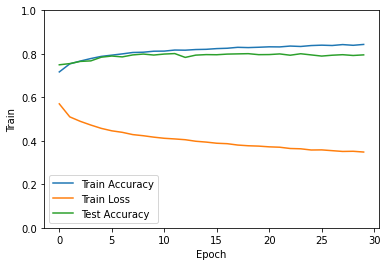

In [31]:

    plt.xlabel('Epoch')
    plt.ylabel('Train')
    plt.plot(hist['epoch'], hist['train_acc'],
           label='Train Accuracy')
    plt.plot(hist['epoch'], hist['train_loss'],
           label = 'Train Loss')
    plt.plot(hist['epoch'], hist['test_acc'],
           label = 'Test Accuracy')
    plt.ylim([0,1])
    plt.legend()
    plt.savefig('../huggingface/visual_result/AAV2_single_mutant_nab_Bert_aav_30epoch.png',dpi=300)#save result
    plt.show()


In [37]:
#3 external evaluation

<Figure size 432x288 with 0 Axes>

In [76]:
args = TrainingArguments(
    "aav2bert-finetuning",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    push_to_hub=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [78]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset[validation_key],
    tokenizer=tokenizer，
    compute_metrics=compute_metrics
)